Diego García Maroto (diegar20@ucm.es)

# Práctica 2: Análisis de extremos, análisis espectral y filtros

In [1]:
### IMPORTS ###
# Módulos básicos y otros
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd

# Estadística
from scipy import stats 
from scipy import special

# Cartografía 
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
from cartopy.util import add_cyclic_point
import cartopy.io.shapereader as shpreader

# Lectura de datos
from netCDF4 import Dataset
import xarray as xr

# Índices Climáticos
from xclim.core.calendar import percentile_doy
from xclim.indices import tn10p, tx10p

Vamos a calcular los siguientes indices de extremos:

![title](./img/index.png)

Lectura de datos (necesitaremos tanto Tmax como Tmin):

In [2]:
path = './data/'
file_max = 'tmax_pen.nc'
data_max = xr.open_dataset(path+file_max)
file_min = 'tmin_pen.nc'
data_min = xr.open_dataset(path+file_min)
display(data_max)
data_min

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tx       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily maximum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, maximum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

<xarray.Dataset>
Dimensions:  (lon: 230, lat: 190, Time: 41638)
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Data variables:
    tn       (Time, lat, lon) float32 ...
Attributes: (12/13)
    title:             Daily minimum temperature of peninsular Spain
    history:           version 1.0
    keywords:          daily, minimum temperature, peninsular Spain, Spain
    creator_name:      Roberto Serrano-Notivoli; Martin de Luis; Santiago Beg...
    maintainer_name:   Roberto Serrano-Notivoli
    maintainer_email:  rs@unizar.es
    ...                ...
    processing_level:  Quality-controlled. Final values.
    acknowledgment:    This study was supported by research projects financed...
    units:             Celsius degrees
    id:                STEAD
    sources:           AEMET and MAGRAMA
    naming_authority:  Spanish TEmperature At Daily scale

In [3]:
# Separamos las variables (las lat y lon son las mismas al ser la misma base de datos)
lon = data_min.lon
lat = data_min.lat
tmin = data_min.tn
tmax = data_max.tx
display(tmax)
display(tmin)

<xarray.DataArray 'tx' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Maximum temperature

<xarray.DataArray 'tn' (Time: 41638, lat: 190, lon: 230)>
[1819580600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -9.673 -9.614 -9.556 -9.497 ... 3.607 3.665 3.724
  * lat      (lat) float64 44.17 44.12 44.08 44.03 ... 35.8 35.75 35.71 35.66
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

---

Calculamos las cold_nights:

In [4]:
# Defino funciones para calcular el índice y los percentiles mediante el módulo xclim
def cold_nights_xclim(tmin:xr.DataArray, period:list, ref_period=['1961','1990']):
    try:
        tmin.time
        print('Funciono bien :)')
    except: 
        tmin = tmin.rename({'Time': 'time'})
        print('Te he cambiado el tiempo')
    #tmin = tmin.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmin.attrs['units'] = 'degC'
    base = tmin.sel(time=slice('1961','1990'))
    tmin_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmin.sel(time=slice(period[0],period[1])), tmin_per)
    percent_cold_nights = num_cold/365*100
    print('>> Índice calculado')
    return tmin_per, percent_cold_nights

def cold_days_xclim(tmax:xr.DataArray, period:list, ref_period=['1961','1990']):
    try: tmax.time
    except: tmax = tmax.rename({'Time': 'time'})
    #tmax = tmax.convert_calendar('noleap',dim='time')
    print('>> Calculando percentiles')
    tmax.attrs['units'] = 'degC'
    base = tmax.sel(time=slice('1961','1990'))
    tmax_per = percentile_doy(base, per=10).sel(percentiles=10)
    print('>> Percentiles calculados')
    print('>> Calculando indice')
    num_cold = tn10p(tmax.sel(time=slice(period[0],period[1])), tmax_per)
    percent_cold_days = num_cold/365*100
    print('>> Índice calculado')
    return tmax_per, percent_cold_days


In [5]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tminO = tmin.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmin_p10_O = xr.open_dataarray('./outs/tmin_p10_O.nc')
    percent_cold_nights_O = xr.open_dataarray('./outs/percent_cold_nights_O.nc')
except: 
    tmin_p10_O, percent_cold_nights_O = cold_nights_xclim(tminO,['1901','2014'])
    tmin_p10_O.to_netcdf('./outs/tmin_p10_O.nc')
    percent_cold_nights_O.to_netcdf('./outs/percent_cold_nights_O.nc')
display(tmin_p10_O)
display(percent_cold_nights_O)

<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
[746640 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:30:33] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
[232560 values with dtype=float64]
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

In [7]:
try: 
    tmin_p10_E = xr.open_dataarray('./outs/tmin_p10_E.nc')
    percent_cold_nights_E = xr.open_dataarray('./outs/percent_cold_nights_E.nc')
    print('Leido de outs')
except:
    tmin_p10_E, percent_cold_nights_E = cold_nights_xclim(tmin.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmin_p10_E.to_netcdf('./outs/tmin_p10_E.nc')
    percent_cold_nights_E.to_netcdf('./outs/percent_cold_nights_E.nc')

Leido de outs


In [8]:
try: 
    tmin_p10_C = xr.open_dataarray('./outs/tmin_p10_C.nc')
    percent_cold_nights_C = xr.open_dataarray('./outs/percent_cold_nights_C.nc')
    print('Leido de outs')
except:
    tmin_p10_C, percent_cold_nights_C = cold_nights_xclim(tmin.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmin_p10_C.to_netcdf('./outs/tmin_p10_C.nc')
    percent_cold_nights_C.to_netcdf('./outs/percent_cold_nights_C.nc')

Leido de outs


In [9]:
try: 
    tmin_p10_S = xr.open_dataarray('./outs/tmin_p10_S.nc')
    percent_cold_nights_S = xr.open_dataarray('./outs/percent_cold_nights_S.nc')
    print('Leido de outs')
except:
    tmin_p10_S, percent_cold_nights_S = cold_nights_xclim(tmin.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmin_p10_S.to_netcdf('./outs/tmin_p10_S.nc')
    percent_cold_nights_S.to_netcdf('./outs/percent_cold_nights_S.nc')


Leido de outs


In [10]:
try: 
    tmin_p10_N = xr.open_dataarray('./outs/tmin_p10_N.nc')
    percent_cold_nights_N = xr.open_dataarray('./outs/percent_cold_nights_N.nc')
    print('Leido de outs')
except:
    tmin_p10_N, percent_cold_nights_N = cold_nights_xclim(tmin.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmin_p10_N.to_netcdf('./outs/tmin_p10_N.nc')
    percent_cold_nights_N.to_netcdf('./outs/percent_cold_nights_N.nc')


Leido de outs


<xarray.DataArray ()>
array(16.34943523)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(20.84114396)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(19.47849075)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(21.20644076)
Coordinates:
    percentiles  int32 ...
<xarray.DataArray ()>
array(15.23912521)
Coordinates:
    percentiles  int32 ...


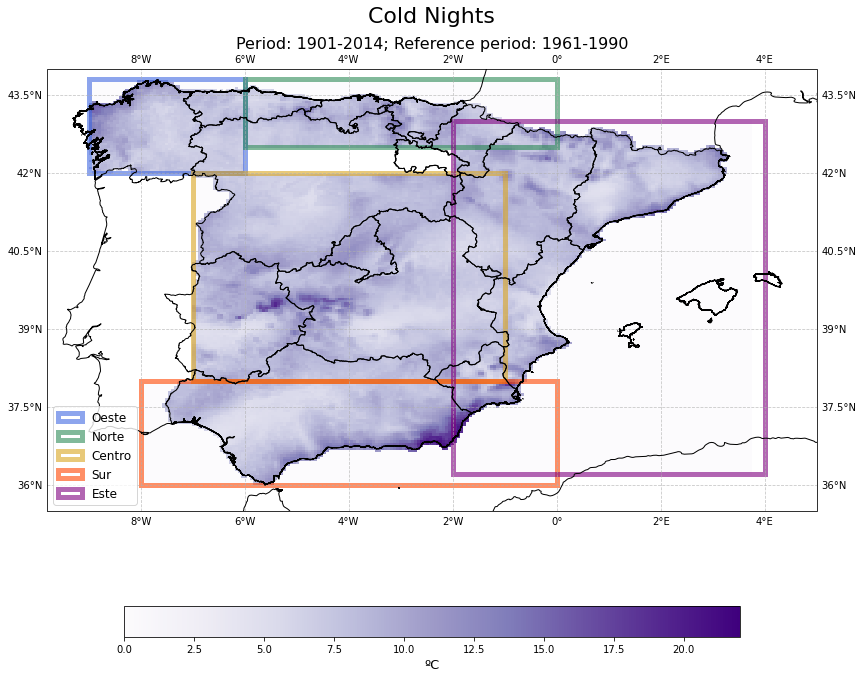

In [12]:
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Nights',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Purples'

var = percent_cold_nights_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = percent_cold_nights_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var = percent_cold_nights_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var = percent_cold_nights_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var = percent_cold_nights_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='ºC',size=13)
cbar.ax.set_xlim(0, 22)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

In [27]:
#fig.savefig('cold_nights.png',dpi=600,facecolor='w')

Ahora las series temporales:

In [37]:
from matplotlib import style

def series_style():
    plt.style.use('seaborn') # Estilo general

    font = {'size'   : 14}
    plt.rc('font', **font) # Tamaño generico de fuentes
    parameters = {'xtick.labelsize':14,
                'ytick.labelsize':14,
                'axes.labelsize':14,
                'axes.labelweight':'bold',
                'axes.titleweight':'bold',
                'axes.titlesize':18,
                'legend.fontsize':15,
                'legend.frameon':True,
                'legend.facecolor':'w',
                'legend.title_fontsize':16,
                'ytick.major.size': 3.5,
                'ytick.major.width': 0.8,
                'xtick.major.size': 3.5,
                'xtick.major.width': 0.8,  
                'axes.linewidth':1,
                'axes.edgecolor':'grey',
                'xtick.color':'grey',
                'xtick.labelcolor':'k',
                'ytick.color':'grey',
                'ytick.labelcolor':'k'}
    plt.rcParams.update(parameters)

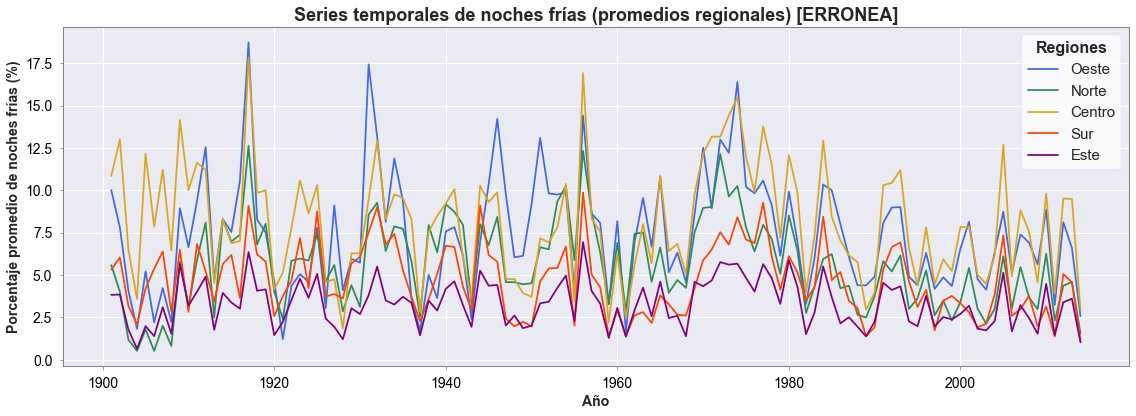

In [38]:
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,percent_cold_nights_O.mean(dim=['lon','lat']),color='royalblue',label='Oeste')
ax.plot(años,percent_cold_nights_N.mean(dim=['lon','lat']),color='seagreen',label='Norte')
ax.plot(años,percent_cold_nights_C.mean(dim=['lon','lat']),color='goldenrod',label='Centro')
ax.plot(años,percent_cold_nights_S.mean(dim=['lon','lat']),color='orangered',label='Sur')
ax.plot(años,percent_cold_nights_E.mean(dim=['lon','lat']),color='purple',label='Este')
ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales) [ERRONEA]')
plt.tight_layout()

In [16]:
display(tmin_p10_E.sel(lon='4',lat='39', method="nearest"))
display(percent_cold_nights_O)

<xarray.DataArray 'per' (dayofyear: 366)>
[366 values with dtype=float64]
Coordinates:
    lon          float64 3.724
    lat          float64 38.99
    percentiles  int32 ...
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 00:34:29] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      , 10.684932, ...,  5.753425,  5.479452],
        [ 0.      ,  9.589041, ...,  6.027397,  6.849315]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  8.493151, ...,  7.123288,  6.027397],
        [ 0.      ,  8.219178, ...,  8.219178,  7.123288]],

       ...,

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  5.479452, ..., 13.150685, 14.794521],
        [ 0.      ,  5.479452, ..., 13.972603, 14.794521]],

       [[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.      ,  1.09589 , ...,  6.849315,  6.575342],
        [ 0.      ,  0.547945, ...,  6.575342,  6.849315]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 ...
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

Hay que corregirlas, volver a poner los nan en las zonas de océano (si no se infravalora el porcentaje):

In [17]:
def correct_series(percent,tmin=tmin):
    tminR = tmin.sel(lat=slice(float(np.nanmax(percent.lat)),float(np.min(percent.lat))),lon=slice(float(np.min(percent.lon)),float(np.max(percent.lon))),Time=slice('1901','2014'))
    tminR_year = tminR.sel(Time=((tminR.Time.dt.month == 6) & (tminR.Time.dt.day == 1)))
    #tminR_year = tminR.groupby('Time.year').max('Time')
    corr_R = np.where(np.isnan(tminR_year),np.nan,percent)
    return np.nanmean(corr_R,axis=(1,2))

In [19]:
corr_E = correct_series(percent_cold_nights_E)

In [20]:
corr_N = correct_series(percent_cold_nights_N)

In [21]:
corr_S = correct_series(percent_cold_nights_S)

In [22]:
corr_O = correct_series(percent_cold_nights_O)

In [23]:
corr_C = correct_series(percent_cold_nights_C)

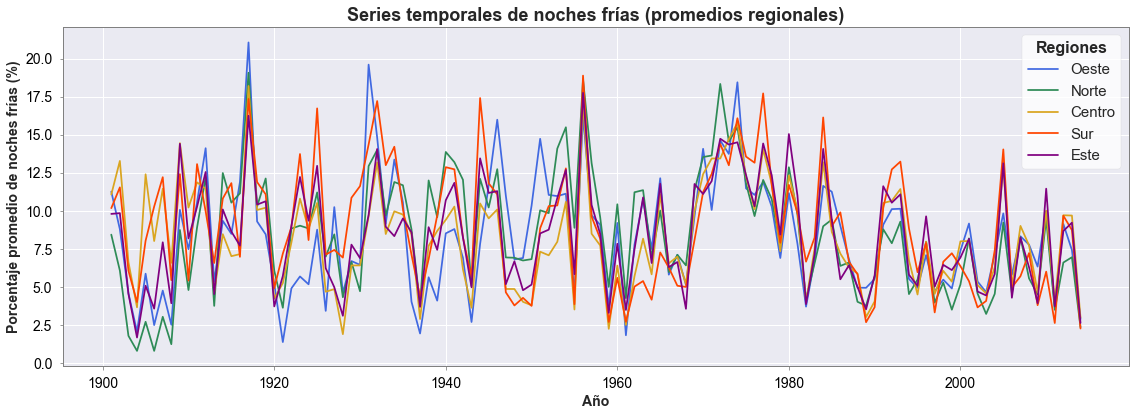

In [24]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,corr_N,color='seagreen',label='Norte')
ax.plot(años,corr_C,color='goldenrod',label='Centro')
ax.plot(años,corr_S,color='orangered',label='Sur')
ax.plot(años,corr_E,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

In [120]:
#fig.savefig('series_reg.png',dpi=600,facecolor='w')

In [109]:
tminOm = tminO.mean(dim=['lon','lat'],keep_attrs=True)
tminOm



<xarray.DataArray 'tn' (Time: 41638)>
array([ 2.3032253 ,  1.679131  ,  1.7624679 , ..., -1.5089166 ,
       -1.5696096 , -0.08151622], dtype=float32)
Coordinates:
  * Time     (Time) datetime64[ns] 1901-01-02 1901-01-03 ... 2015-01-01
Attributes:
    units:      Celsius degrees
    long_name:  Minimum temperature

In [113]:
tminOm = tminOm.rename({'Time': 'time'})
tminOm.attrs['units'] = 'degC'

In [115]:
basem = tminOm.sel(time=slice('1961','1990'))
basem

<xarray.DataArray 'tn' (time: 10957)>
array([2.3487177 , 0.86258835, 2.015206  , ..., 3.645706  , 5.783328  ,
       5.418103  ], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1961-01-01 1961-01-02 ... 1990-12-31
Attributes:
    units:      degC
    long_name:  Minimum temperature

In [116]:
tas_perm = percentile_doy(basem, per=10).sel(percentiles=10)
cold_daysm = tn10p(tminOm.sel(time=slice('1901','2014')), tas_perm)

In [117]:
perm = cold_daysm/365*100

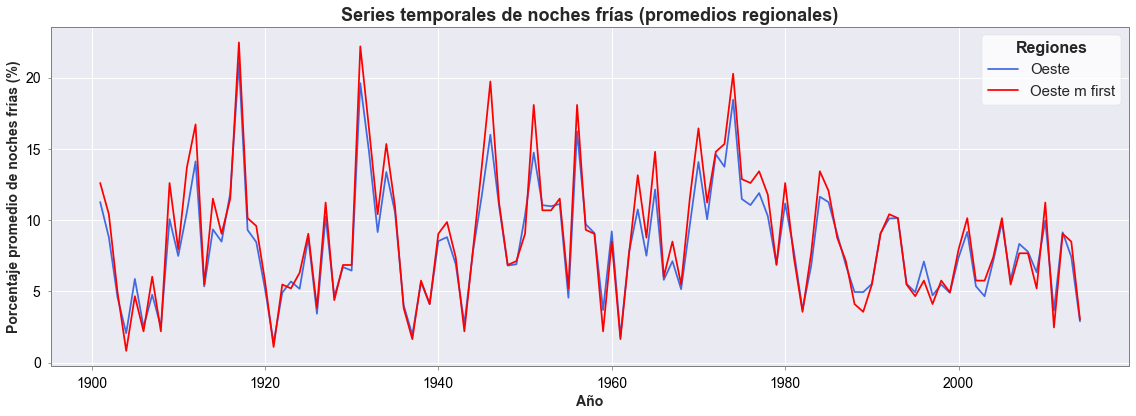

In [118]:
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O,color='royalblue',label='Oeste')
ax.plot(años,perm,color='r',label='Oeste m first')


ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de noches frías (%)')
ax.set_title('Series temporales de noches frías (promedios regionales)')
plt.tight_layout()

---

Vamos con los cold_days:

In [25]:
lat_oeste = [42,43.8]
lon_oeste = [-9,-6]
tmaxO = tmax.sel(lon=slice(lon_oeste[0],lon_oeste[1]),lat=slice(lat_oeste[1],lat_oeste[0]))
try:
    tmax_p10_O = xr.open_dataarray('./outs/tmax_p10_O.nc')
    percent_cold_days_O = xr.open_dataarray('./outs/percent_cold_days_O.nc')
except: 
    tmax_p10_O, percent_cold_days_O = cold_nights_xclim(tminO,['1901','2014'])
    tmax_p10_O.to_netcdf('./outs/tmax_p10_O.nc')
    percent_cold_days_O.to_netcdf('./outs/percent_cold_days_O.nc')
display(tmax_p10_O)
display(percent_cold_days_O)

Te he cambiado el tiempo
>> Calculando percentiles


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\xclim\core\utils.py:429: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


>> Percentiles calculados
>> Calculando indice
>> Índice calculado


<xarray.DataArray 'per' (lat: 40, lon: 51, dayofyear: 366)>
array([[[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        ...,
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
...
        [-6.00000000e+00, -6.00000000e+00, -6.00000000e+00, ...,
         -4.00294061e+00, -4.53793035e+00, -5.00000000e+00],
        [-6.00000000e+00, -6.00000000e+00, -6.00000000e+00, ...,
         -4.00000000e+00, -4.00273093e+00, -4.99678930e+00],
        [-5.96557816e+00, -5.99990569e+00, -6.00000000e+00, ...,
         -4.00000000e+00, -4.00246510e+00, -4.89976160e+00]],

       [[            nan,             nan,             nan, ...,
                     nan,             nan,             nan],
        [ 7.03543772e-02,  1.92751718e-04,  4.76607743e-01, ...,
          1.00000000e+00,  9.97453026e-01,  7.03543772e-02],
        [ 8.90937696e-03,  1.42403576e-02,  1.54537279e-01, ...,
          6.47306342e-01,  3.09962317e-01,  7.04319154e-02],
        ...,
        [-6.00000000e+00, -6.00000000e+00, -6.00000000e+00, ...,
         -4.00232520e+00, -4.42592570e+00, -5.00000000e+00],
        [-5.99709829e+00, -5.99999205e+00, -6.00000000e+00, ...,
         -4.00010760e+00, -4.02232329e+00, -5.00000000e+00],
        [-5.97131681e+00, -5.99992142e+00, -6.00000000e+00, ...,
         -3.98954055e+00, -4.00272663e+00, -4.99521947e+00]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * dayofyear    (dayofyear) int32 1 2 3 4 5 6 7 ... 360 361 362 363 364 365 366
Attributes:
    units:               °C
    long_name:           Minimum temperature
    climatology_bounds:  ['1961-01-01', '1990-12-31']
    window:              5
    alpha:               0.3333333333333333
    beta:                0.3333333333333333
    history:             [2022-11-17 16:17:34] per: percentile_doy(arr=tn, wi...

<xarray.DataArray (time: 114, lat: 40, lon: 51)>
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [11.50684932, 13.97260274, 16.43835616, ...,  5.20547945,
          5.75342466,  5.75342466],
        [ 0.        , 10.68493151, 18.08219178, ...,  5.75342466,
          5.75342466,  5.47945205],
        [ 0.        ,  9.5890411 , 16.43835616, ...,  6.02739726,
          6.02739726,  6.84931507]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
...
        [ 5.47945205,  7.39726027,  7.39726027, ..., 13.69863014,
         14.52054795, 16.98630137],
        [ 0.        ,  5.47945205,  6.57534247, ..., 11.50684932,
         13.15068493, 14.79452055],
        [ 0.        ,  5.47945205,  6.57534247, ..., 11.78082192,
         13.97260274, 14.79452055]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [ 1.36986301,  1.64383562,  1.36986301, ...,  6.84931507,
          8.49315068,  7.67123288],
        [ 0.        ,  1.09589041,  1.09589041, ...,  6.84931507,
          6.84931507,  6.57534247],
        [ 0.        ,  0.54794521,  1.64383562, ...,  5.20547945,
          6.57534247,  6.84931507]]])
Coordinates:
  * lon          (lon) float64 -8.971 -8.912 -8.854 ... -6.163 -6.104 -6.046
  * lat          (lat) float64 43.76 43.72 43.67 43.63 ... 42.1 42.05 42.01
    percentiles  int32 10
  * time         (time) datetime64[ns] 1901-01-01 1902-01-01 ... 2014-01-01

In [26]:
try: 
    tmax_p10_E = xr.open_dataarray('./outs/tmax_p10_E.nc')
    percent_cold_days_E = xr.open_dataarray('./outs/percent_cold_days_E.nc')
    print('Leido de outs')
except:
    tmax_p10_E, percent_cold_days_E = cold_nights_xclim(tmax.sel(lat=slice(43,36.2),lon=slice(-2,4)),['1901','2014'])
    tmax_p10_E.to_netcdf('./outs/tmax_p10_E.nc')
    percent_cold_days_E.to_netcdf('./outs/percent_cold_days_E.nc')

Te he cambiado el tiempo
>> Calculando percentiles


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\xclim\core\utils.py:429: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


>> Percentiles calculados
>> Calculando indice
>> Índice calculado


In [27]:
try: 
    tmax_p10_C = xr.open_dataarray('./outs/tmax_p10_C.nc')
    percent_cold_days_C = xr.open_dataarray('./outs/percent_cold_days_C.nc')
    print('Leido de outs')
except:
    tmax_p10_C, percent_cold_days_C = cold_nights_xclim(tmax.sel(lat=slice(42,38),lon=slice(-7, -1)),['1901','2014'])
    tmax_p10_C.to_netcdf('./outs/tmax_p10_C.nc')
    percent_cold_days_C.to_netcdf('./outs/percent_cold_days_C.nc')

Te he cambiado el tiempo
>> Calculando percentiles


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\xclim\core\utils.py:429: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


>> Percentiles calculados
>> Calculando indice
>> Índice calculado


In [28]:
try: 
    tmax_p10_S = xr.open_dataarray('./outs/tmax_p10_S.nc')
    percent_cold_days_S = xr.open_dataarray('./outs/percent_cold_days_S.nc')
    print('Leido de outs')
except:
    tmax_p10_S, percent_cold_days_S = cold_nights_xclim(tmax.sel(lat=slice(38,36),lon=slice(-8, 0)),['1901','2014'])
    tmax_p10_S.to_netcdf('./outs/tmax_p10_S.nc')
    percent_cold_days_S.to_netcdf('./outs/percent_cold_days_S.nc')

Te he cambiado el tiempo
>> Calculando percentiles


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\xclim\core\utils.py:429: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


>> Percentiles calculados
>> Calculando indice
>> Índice calculado


In [29]:
try: 
    tmax_p10_N = xr.open_dataarray('./outs/tmax_p10_N.nc')
    percent_cold_days_N = xr.open_dataarray('./outs/percent_cold_days_N.nc')
    print('Leido de outs')
except:
    tmax_p10_N, percent_cold_days_N = cold_nights_xclim(tmax.sel(lat=slice(43.8,42.5),lon=slice(-6,0)),['1901','2014'])
    tmax_p10_N.to_netcdf('./outs/tmax_p10_N.nc')
    percent_cold_days_N.to_netcdf('./outs/percent_cold_days_N.nc')


Te he cambiado el tiempo
>> Calculando percentiles


c:\Users\digar7\anaconda3\envs\env1\lib\site-packages\xclim\core\utils.py:429: RuntimeWarning: All-NaN slice encountered
  result = np.where(np.isnan(interpolation), np.nanmax(arr, axis=0), interpolation)


>> Percentiles calculados
>> Calculando indice
>> Índice calculado


<xarray.DataArray ()>
array(16.34943523)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(15.71497236)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(18.02451334)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(14.48209565)
Coordinates:
    percentiles  int32 10
<xarray.DataArray ()>
array(14.94592646)
Coordinates:
    percentiles  int32 10


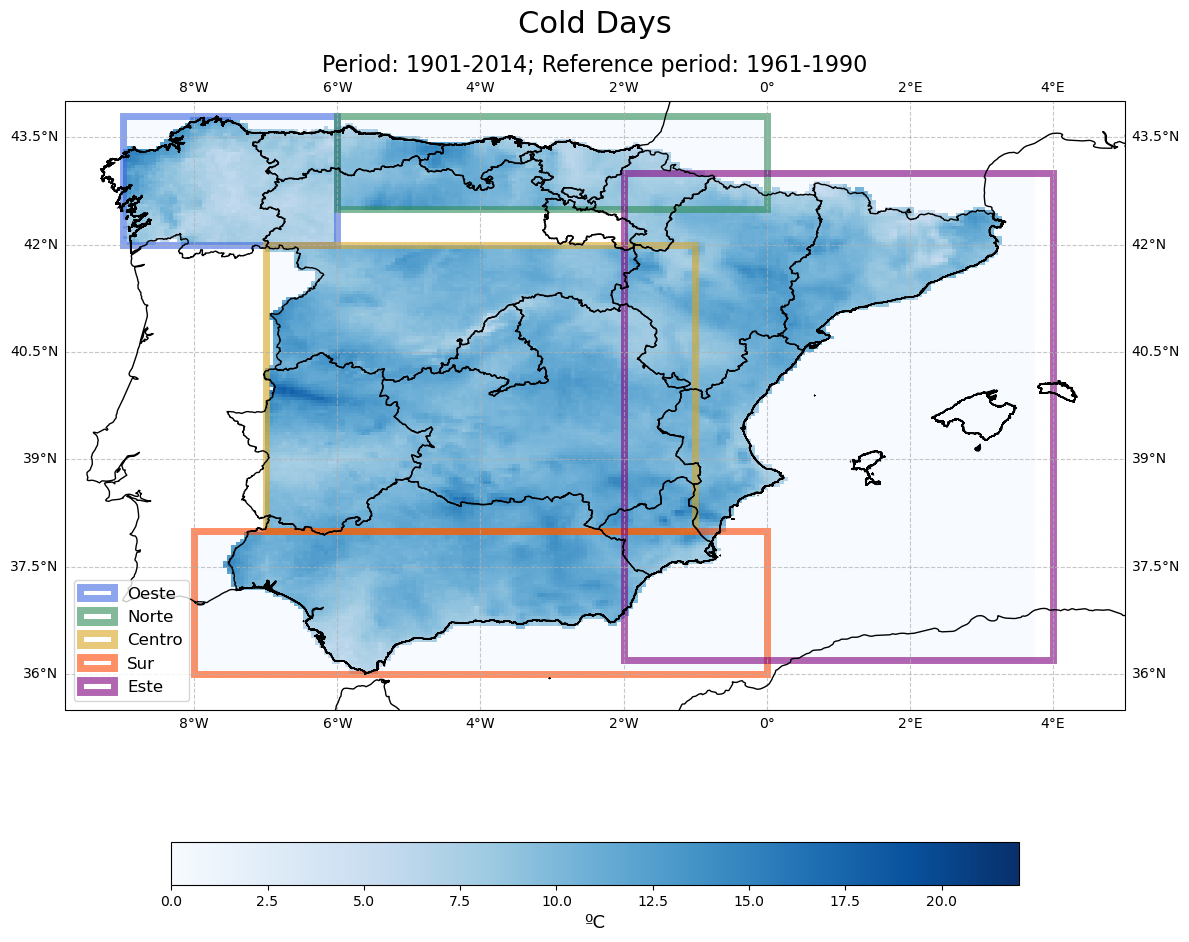

In [40]:
plt.style.use('default')
# Downloaded from http://biogeo.ucdavis.edu/data/gadm2/shp/DEU_adm.zip
fname = './mapas/gadm41_ESP_1.shp'

adm1_shapes = list(shpreader.Reader(fname).geometries())


fig, ax = plt.subplots(figsize=(12, 10), ncols=1)
ax=plt.subplot(1,1,1,projection=ccrs.PlateCarree())

plt.suptitle('Cold Days',size=22)
plt.title('Period: 1901-2014; Reference period: 1961-1990',size=16)
ax.coastlines(resolution='10m')#, linewidth=2)

ax.add_geometries(adm1_shapes, ccrs.PlateCarree(), # Cuidado con los sistemas de coordenadas, esto esta definido solo para este sistema
                  edgecolor='black', facecolor='None', alpha=1)


ax.set_global() # added following an answer to my question
#ax.gridlines()
ax.gridlines(draw_labels = True,linestyle='--',alpha=0.7,zorder=1)

ax.set_extent([-9.8,5,35.5,44], ccrs.PlateCarree())
cmap = 'Blues'

var =  percent_cold_days_O.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var =  percent_cold_days_E.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) # En transform se pone la proyección default en la que está los datos 
print(var.max().squeeze())

var =  percent_cold_days_C.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree()) 
print(var.max().squeeze())


var =  percent_cold_days_S.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


var =  percent_cold_days_N.mean(dim='time')
im = ax.pcolormesh(var.lon,var.lat,var.squeeze(),cmap=cmap,vmin=0, vmax=22, transform =ccrs.PlateCarree())
print(var.max().squeeze())


cbar = fig.colorbar(im,ax=ax,orientation = 'horizontal',shrink=0.8)
cbar.set_label(label='ºC',size=13)
cbar.ax.set_xlim(0, 22)



def pinta_region(lats,lons,color,ax=ax,label=None):
    lat_corners = np.array([lats[0], lats[0],lats[1], lats[1]])
    lon_corners = np.array([ lons[0], lons[1], lons[1], lons[0]])
    poly_corners = np.zeros((len(lat_corners), 2), np.float64)
    poly_corners[:,0] = lon_corners
    poly_corners[:,1] = lat_corners
    poly = mpatches.Polygon(poly_corners, closed=True, ec=color, fill=False, lw=5, fc=color,label=label,alpha=0.6, transform=ccrs.Geodetic()) # geodetic para que transforme los rectángulos a la proyección correcta
    ax.add_patch(poly)


pinta_region([42,43.8],[-9,-6],'royalblue',ax,label='Oeste')
pinta_region([42.5,43.8],[-6,0],'seagreen',ax,label='Norte')
pinta_region([38, 42],[-7, -1],'goldenrod',ax,label='Centro')
pinta_region([36, 38],[-8, 0],'orangered',ax,label='Sur')
pinta_region([36.2, 43],[-2, 4],'purple',ax,label='Este')

ax.legend(prop={'size':12})
plt.tight_layout()

In [31]:
corr_E_d = correct_series(percent_cold_days_E)

In [32]:
corr_N_d = correct_series(percent_cold_days_N)

In [33]:
corr_S_d = correct_series(percent_cold_days_S)

In [34]:
corr_O_d = correct_series(percent_cold_days_O)

In [35]:
corr_C_d = correct_series(percent_cold_days_C)

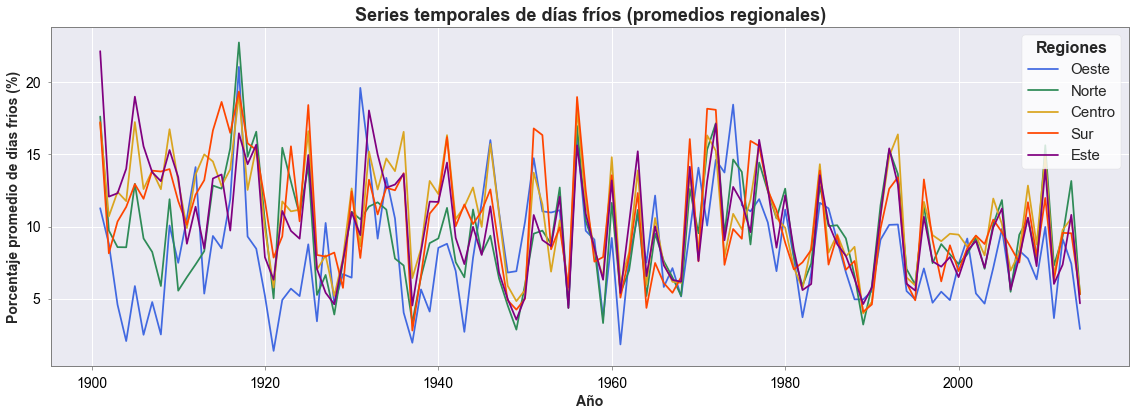

In [39]:
series_style()
fig,ax = plt.subplots(figsize = (16,6))
años = percent_cold_nights_N['time.year']
ax.plot(años,corr_O_d,color='royalblue',label='Oeste')
ax.plot(años,corr_N_d,color='seagreen',label='Norte')
ax.plot(años,corr_C_d,color='goldenrod',label='Centro')
ax.plot(años,corr_S_d,color='orangered',label='Sur')
ax.plot(años,corr_E_d,color='purple',label='Este')

ax.legend(title='Regiones',title_fontproperties={'weight':'bold'}) # Leyenda con título
ax.set_xlabel(u'Año')
ax.set_ylabel(u'Porcentaje promedio de días fríos (%)')
ax.set_title('Series temporales de días fríos (promedios regionales)')
plt.tight_layout()